# Digital Magazine Customer Segmentation

## Data

We're going to do some customer segmentation for a **media company** (a digital magazine) to help them understand the needs of their customers better, and put them into useful groups of similar clusters. There are two datasets each of which is a random sample of `200` customers.

### Behavioral Data

This dataset (behavioral.csv) contains information about the media company customers' behavior on the site. The variables in the customer data include:

- `id`: customer id
- `gender`: self-disclosed gender identity, `male`, `female`, `nonbinary` or `other`
- `age`: age in years
- `current_income`: self-reported current annual income in thousands
- `time_spent_browsing`: average number of minutes spent browsing website per month
- `prop_ad_clicks`: proportion of website ads that they click on (between `0` and `1`)
- `longest_read_time`: longest time spent consecutively on website in minutes
- `length_of_subscription`: number of days subscribed to the magazine
- `monthly_visits`: average number of visits to the site per month



### Article Data

This dataset (topics.csv) contains information about the number of articles customers read in each topic in the past 3 months. The topics in the customer data include:

- `Stocks`
- `Productivity`
- `Fashion`
- `Celebrity`
- `Cryptocurrency`
- `Science`
- `Technology`
- `SelfHelp`
- `Fitness`
- `AI`

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sb
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score, accuracy_score, \
confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt

from PIL import Image

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt



%matplotlib inline

#1. Behavioral Clustering

In [ ]:
# load behavioral data
behavioral = pd.read_csv("https://raw.githubusercontent.com/katherinehansen2/CPSC392Hansen/refs/heads/main/data/HW3_behavioral.csv")
behavioral.head()

,age,current_income,time_spent_browsing,length_of_subscription,monthly_visits,longest_read_time,gender,prop_ads_clicked,id
0,57,74.94,680.185910,344.260552,33.612656,252.092201,man,0.177864,90
1,47,67.01,554.768760,330.549067,28.924096,119.694118,woman,0.138873,1
2,49,66.71,618.436797,247.549601,28.274578,321.450862,woman,0.200859,125
3,47,79.20,560.599752,269.378967,30.471076,179.349038,woman,0.191236,164
4,50,68.39,628.441198,260.282353,32.486453,213.114138,man,0.089133,75


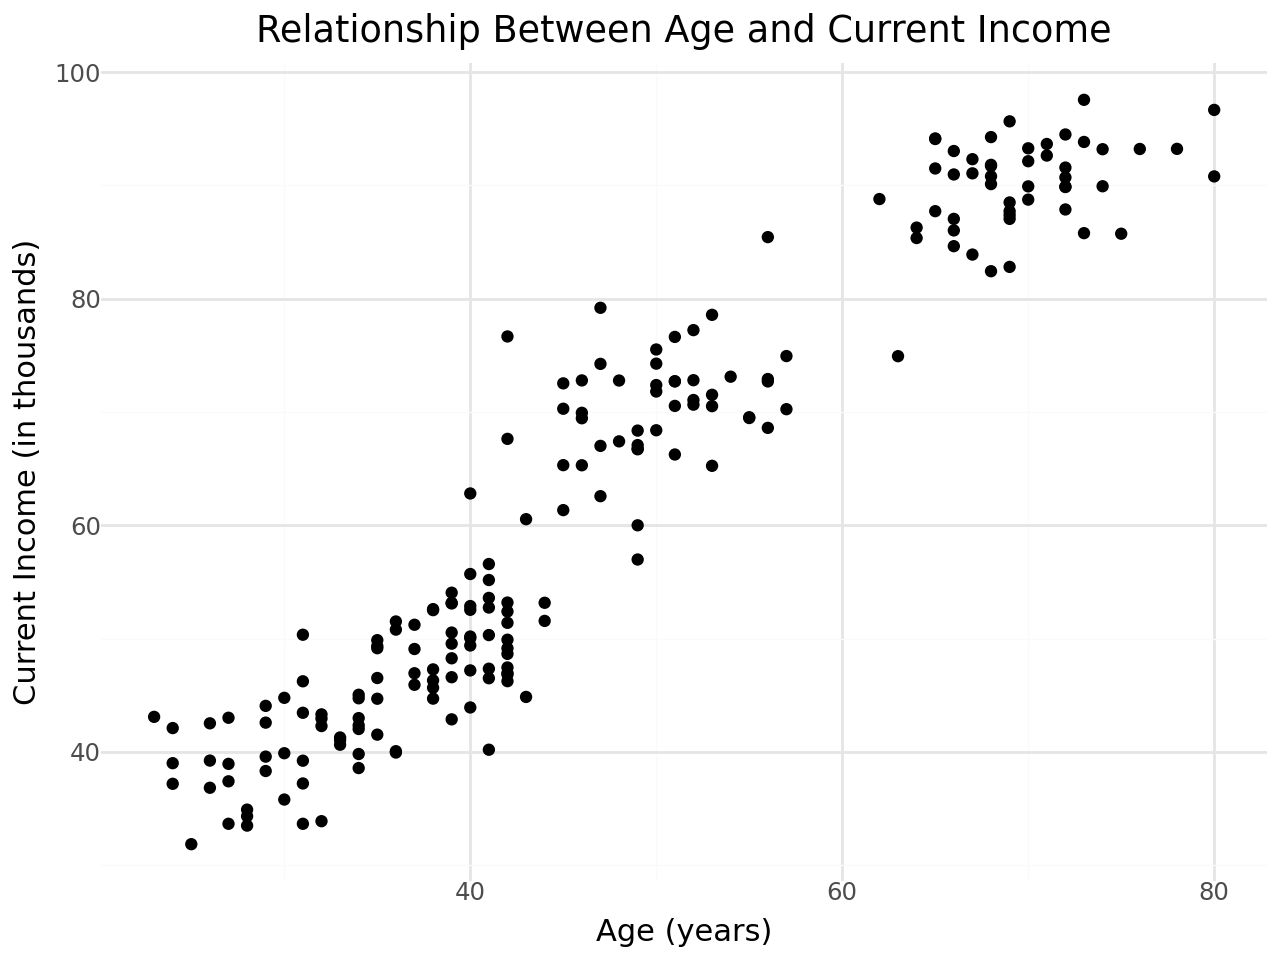

In [ ]:
# pair 1
(ggplot(behavioral, aes(x = "age", y = "current_income",))
+ geom_point()
+ labs(title = "Relationship Between Age and Current Income",
       x = "Age (years)",
       y = "Current Income (in thousands)")
+ theme_minimal())


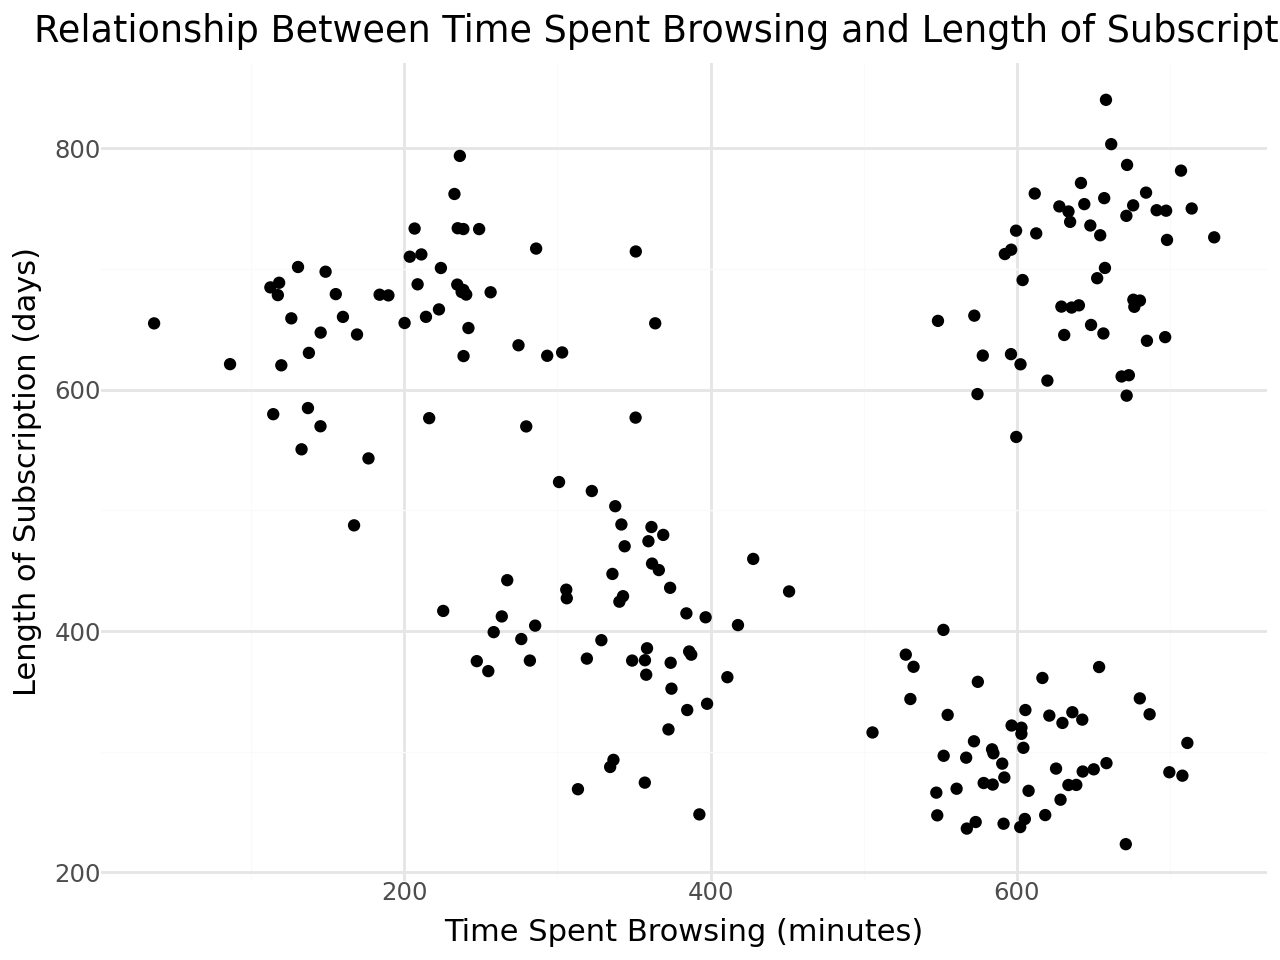

In [ ]:
# pair 2
(ggplot(behavioral, aes(x = "time_spent_browsing", y = "length_of_subscription",))
+ geom_point()
+ labs(title = "Relationship Between Time Spent Browsing and Length of Subscription",
       x = "Time Spent Browsing (minutes)",
       y = "Length of Subscription (days)")
+ theme_minimal())

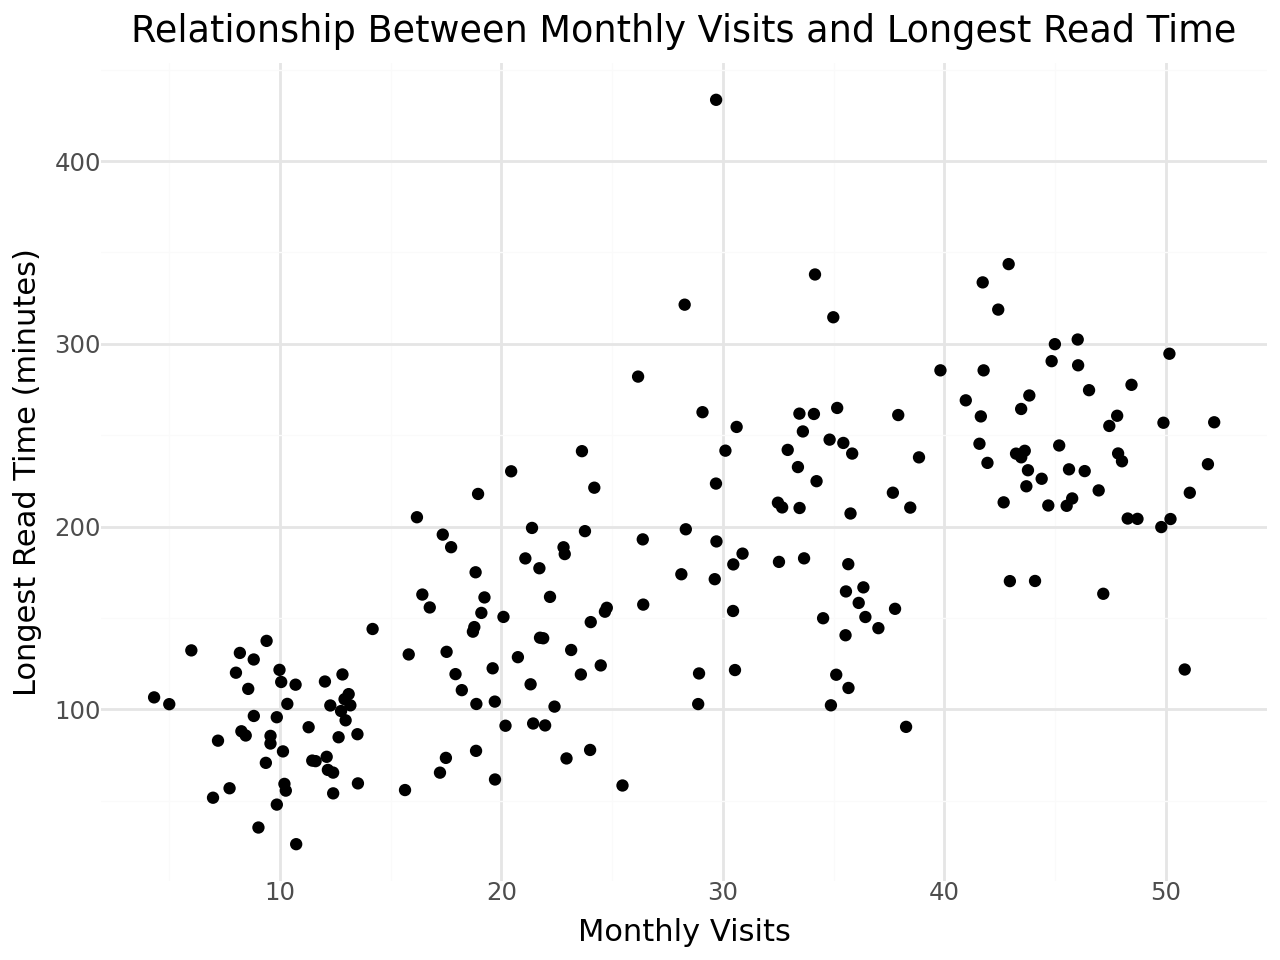

In [ ]:
# pair 3
(ggplot(behavioral, aes(x = "monthly_visits", y = "longest_read_time",))
+ geom_point()
+ labs(title = "Relationship Between Monthly Visits and Longest Read Time",
       x = "Monthly Visits",
       y = "Longest Read Time (minutes)")
+ theme_minimal())

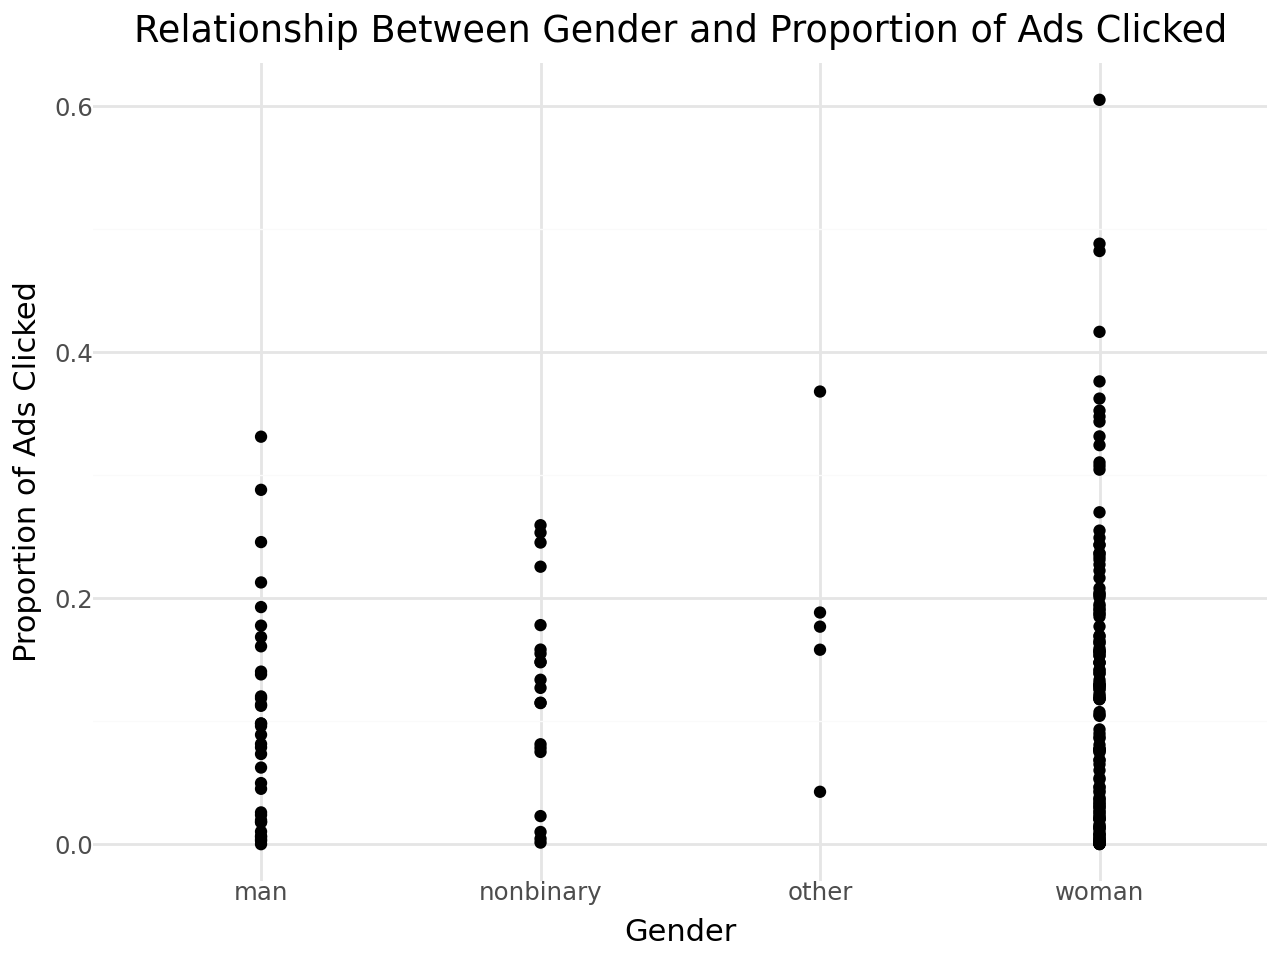

In [ ]:
# pair 4
(ggplot(behavioral, aes(x = "gender", y = "prop_ads_clicked",))
+ geom_point()
+ labs(title = "Relationship Between Gender and Proportion of Ads Clicked",
       x = "Gender",
       y = "Proportion of Ads Clicked")
+ theme_minimal())

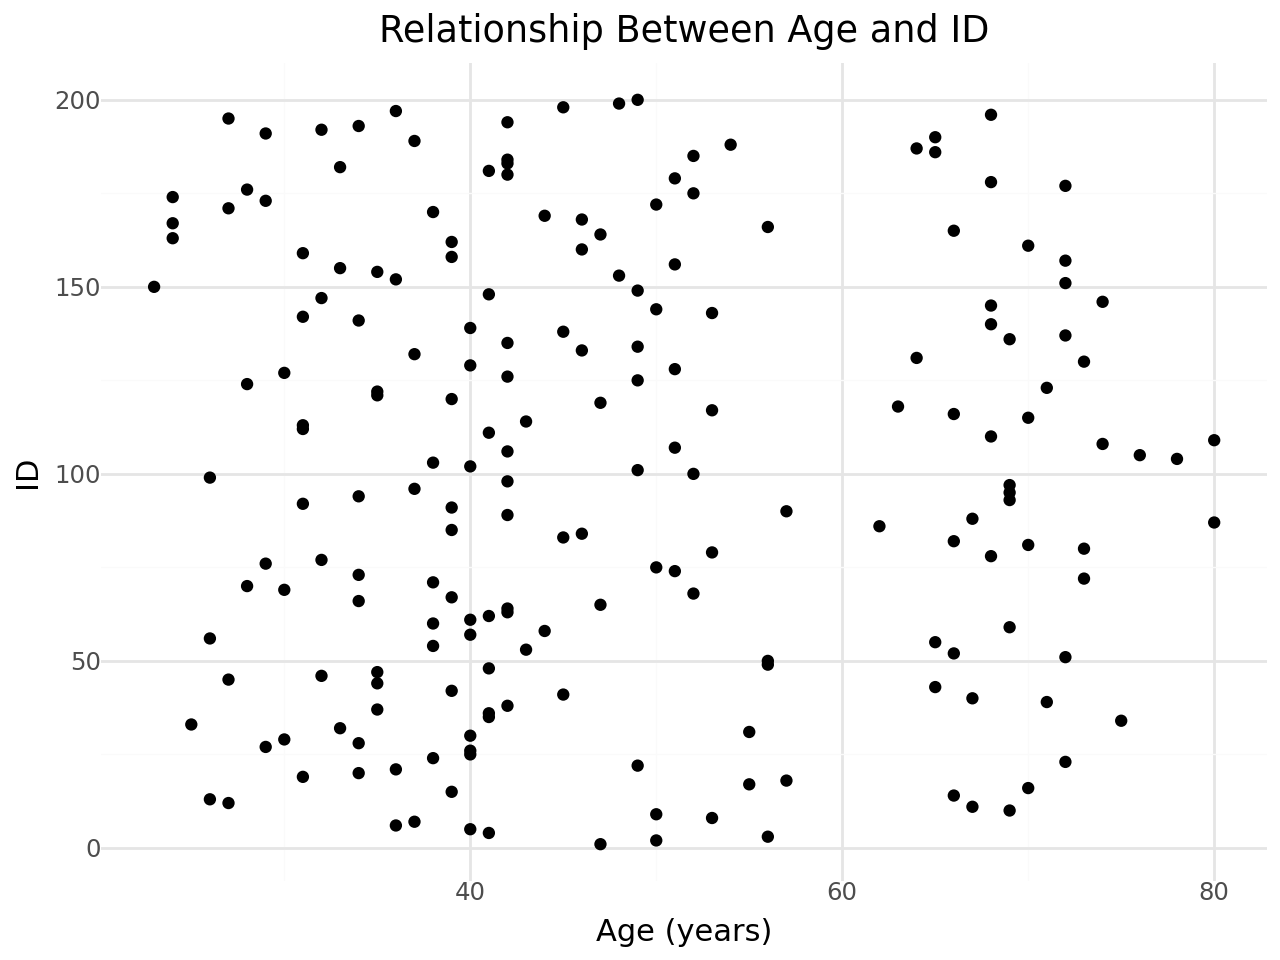

In [ ]:
# pair 5
(ggplot(behavioral, aes(x = "age", y = "id",))
+ geom_point()
+ labs(title = "Relationship Between Age and ID",
       x = "Age (years)",
       y = "ID")
+ theme_minimal())

In [ ]:
behavioral.columns

Index(['age', 'current_income', 'time_spent_browsing',
       'length_of_subscription', 'monthly_visits', 'longest_read_time',
       'gender', 'prop_ads_clicked', 'id'],
      dtype='object')

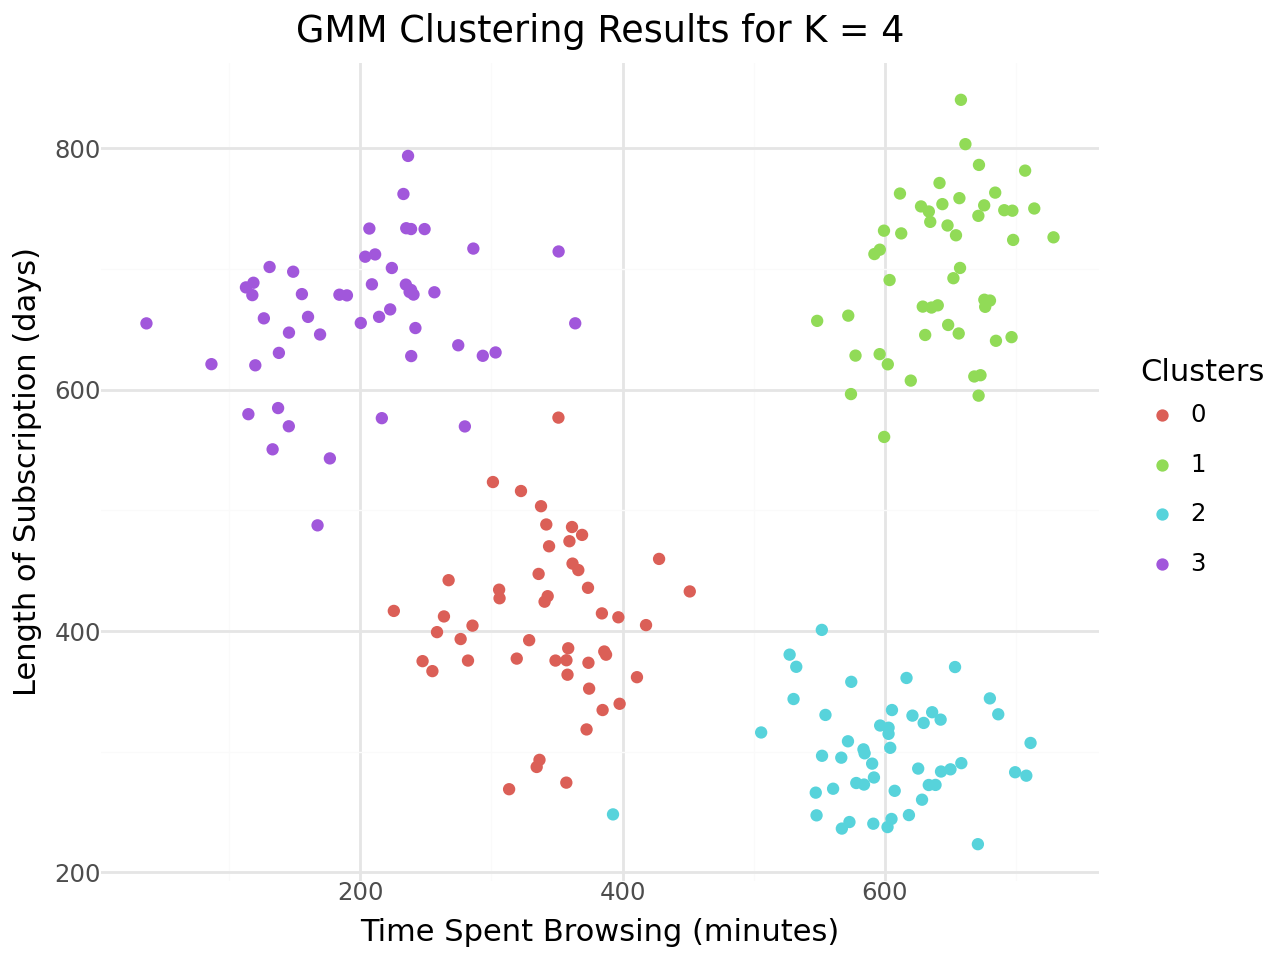

In [ ]:
# GMM model

predictors = ['age', 'current_income', 'time_spent_browsing',
              'length_of_subscription', 'monthly_visits', 'longest_read_time',
              'prop_ads_clicked']

X = behavioral[predictors]

# Z-Score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# empty model
gmm = GaussianMixture(n_components=4)

# fit model + predict
labels = gmm.fit_predict(X_scaled)

# add cluster labels to the original DataFrame
X["clusters"] = labels

# plot the results (pair 2)
(ggplot(X, aes(x="time_spent_browsing", y="length_of_subscription", color="factor(clusters)"))
+ geom_point()
+ labs(title="GMM Clustering Results for K = 4",
       x="Time Spent Browsing (minutes)",
       y="Length of Subscription (days)",
       color="Clusters")
+ theme_minimal())


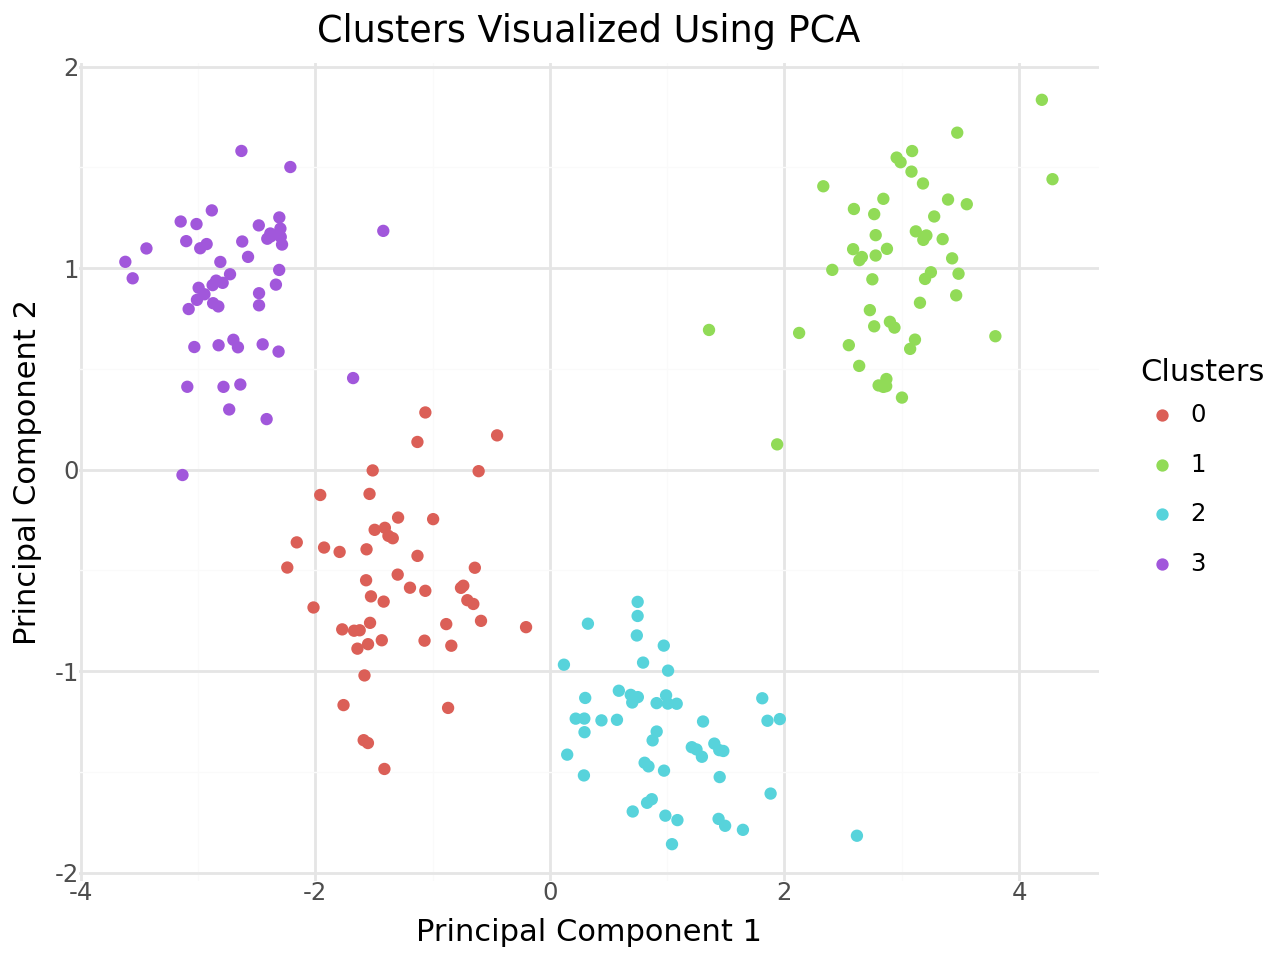

In [ ]:
# PCA

# apply PCA to scaled data
pca = PCA(n_components=2)  # reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# create a DataFrame with PCA components and cluster labels
pcaDF = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pcaDF['clusters'] = labels

# plot
(ggplot(pcaDF, aes(x='PC1', y='PC2', color='factor(clusters)'))
+ geom_point()
+ labs(title="Clusters Visualized Using PCA",
       x="Principal Component 1",
       y="Principal Component 2",
       color="Clusters")
+ theme_minimal())

In [ ]:
# other summary (got help from ChatGPT)
summary_table = pd.DataFrame(X.groupby('clusters').mean()).reset_index()
print(summary_table)

   clusters        age  current_income  time_spent_browsing  \
0         0  39.857143       49.743061           342.060758   
1         1  69.380000       90.149800           645.677263   
2         2  49.862745       69.980196           600.797654   
3         3  30.700000       40.713400           199.091869   

   length_of_subscription  monthly_visits  longest_read_time  prop_ads_clicked  
0              407.616388       21.031827         140.816451          0.065174  
1              698.608170       45.221277         244.238716          0.228305  
2              298.499386       33.074493         206.716388          0.152387  
3              660.924034       10.668075          89.714911          0.051094  


# 2. Article Clustering

In [ ]:
# load article data
article = pd.read_csv("https://raw.githubusercontent.com/katherinehansen2/CPSC392Hansen/refs/heads/main/data/HW3_topics.csv")
article.head()

,Stocks,Productivity,Fashion,Celebrity,Cryptocurrency,Science,Technology,SelfHelp,Fitness,AI,id
0,3,12,9,9,1,1,5,1,0,1,198
1,1,0,1,1,0,8,4,10,4,0,92
2,4,1,11,1,6,11,0,9,0,0,75
3,2,6,8,1,15,1,1,9,8,0,147
4,1,2,4,4,6,6,2,1,3,4,136


In [ ]:
article.columns

Index(['Stocks', 'Productivity', 'Fashion', 'Celebrity', 'Cryptocurrency',
       'Science', 'Technology', 'SelfHelp', 'Fitness', 'AI', 'id'],
      dtype='object')

In [ ]:
# set up features
features = ['Stocks', 'Productivity', 'Fashion', 'Celebrity', 'Cryptocurrency',
            'Science', 'Technology', 'SelfHelp', 'Fitness', 'AI']

# no need to z-score because it is count data
X = article[features]

# create empty model
hac = AgglomerativeClustering(linkage = "average",
                              metric = "cosine",
                              distance_threshold=0,
                              n_clusters = None)


# fit model and get labels
labels = hac.fit_predict(X[features])

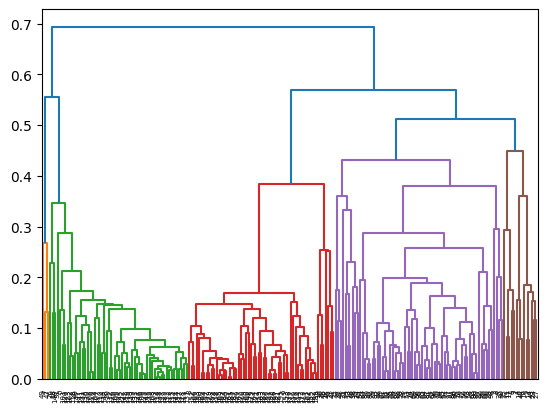

In [ ]:
# from sklearn: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(hac, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(hac.children_.shape[0])
    n_samples = len(hac.labels_)
    for i, merge in enumerate(hac.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [hac.children_, hac.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sch.dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(hac, color_threshold= 0.5)

In [ ]:
# refit with selected number of clusters

hac = AgglomerativeClustering(linkage = "average",
                              metric = "cosine",
                              n_clusters = 5)
labels = hac.fit_predict(X[features])

In [ ]:
article["cluster_5"] = labels
gg_list = []
for test in features:
    title = "Test " + test.capitalize() + " Cluster Performance"
    gg_list.append(ggplot(article, aes(x = "factor(cluster_5)", y = test))
          + geom_boxplot(aes(fill = "factor(cluster_5)")) +
          theme_minimal() +
          scale_fill_discrete(name = "Cluster Assignment") +
          labs(x = "Cluster",
               y = "Score",
               title = title))

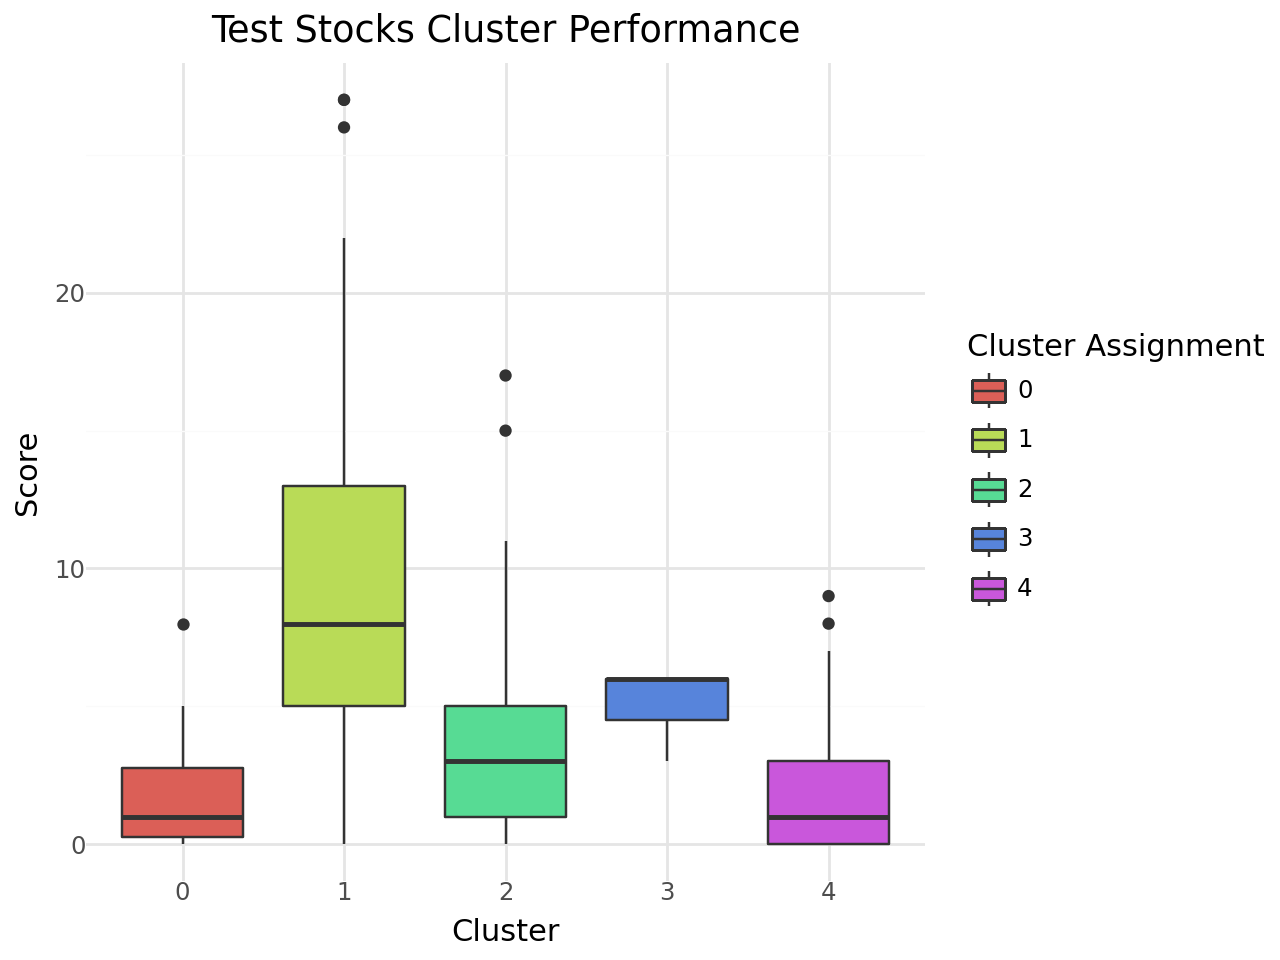

In [ ]:
gg_list[0]

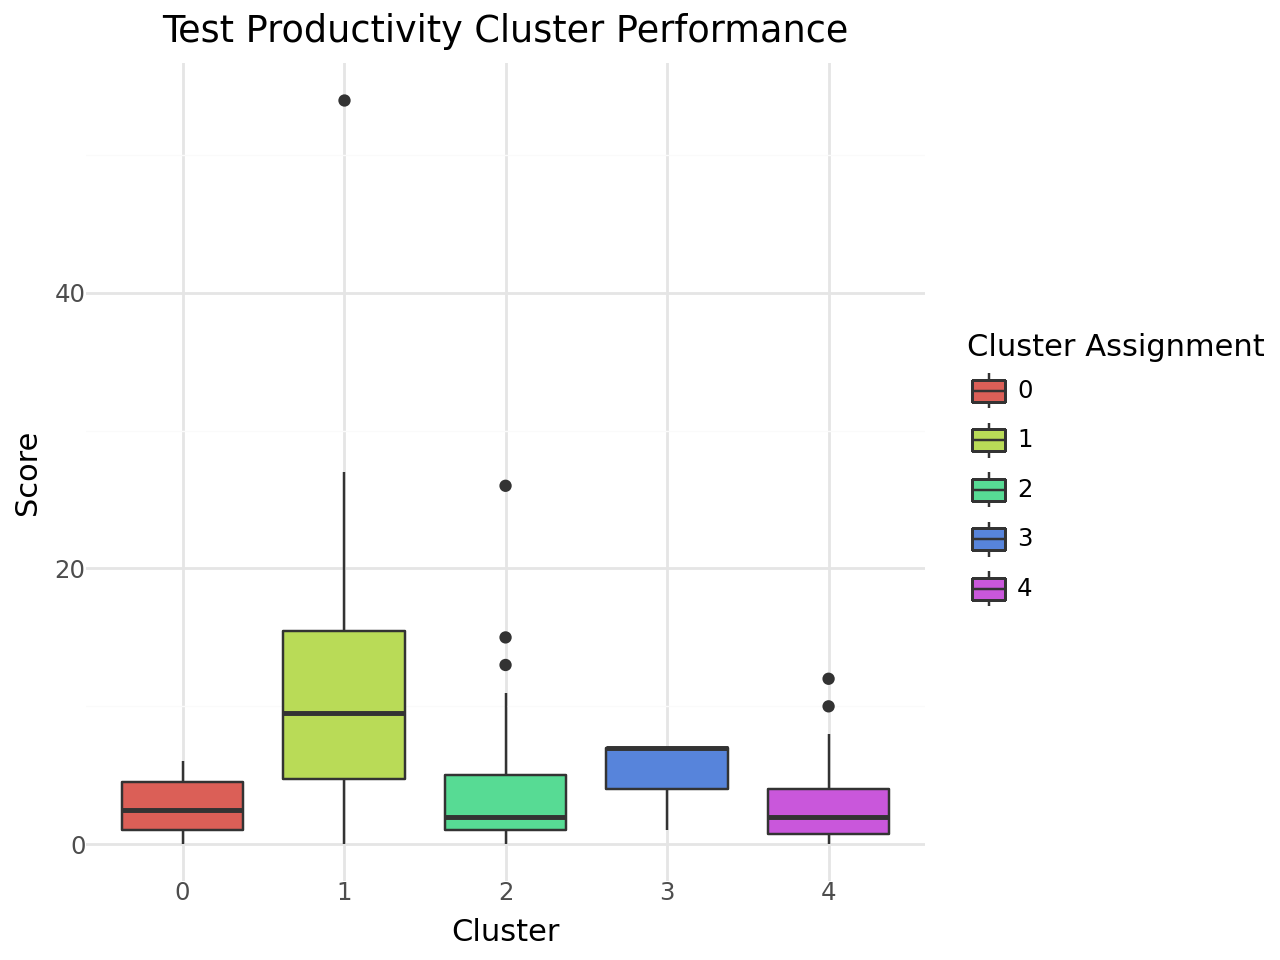

In [ ]:
gg_list[1]

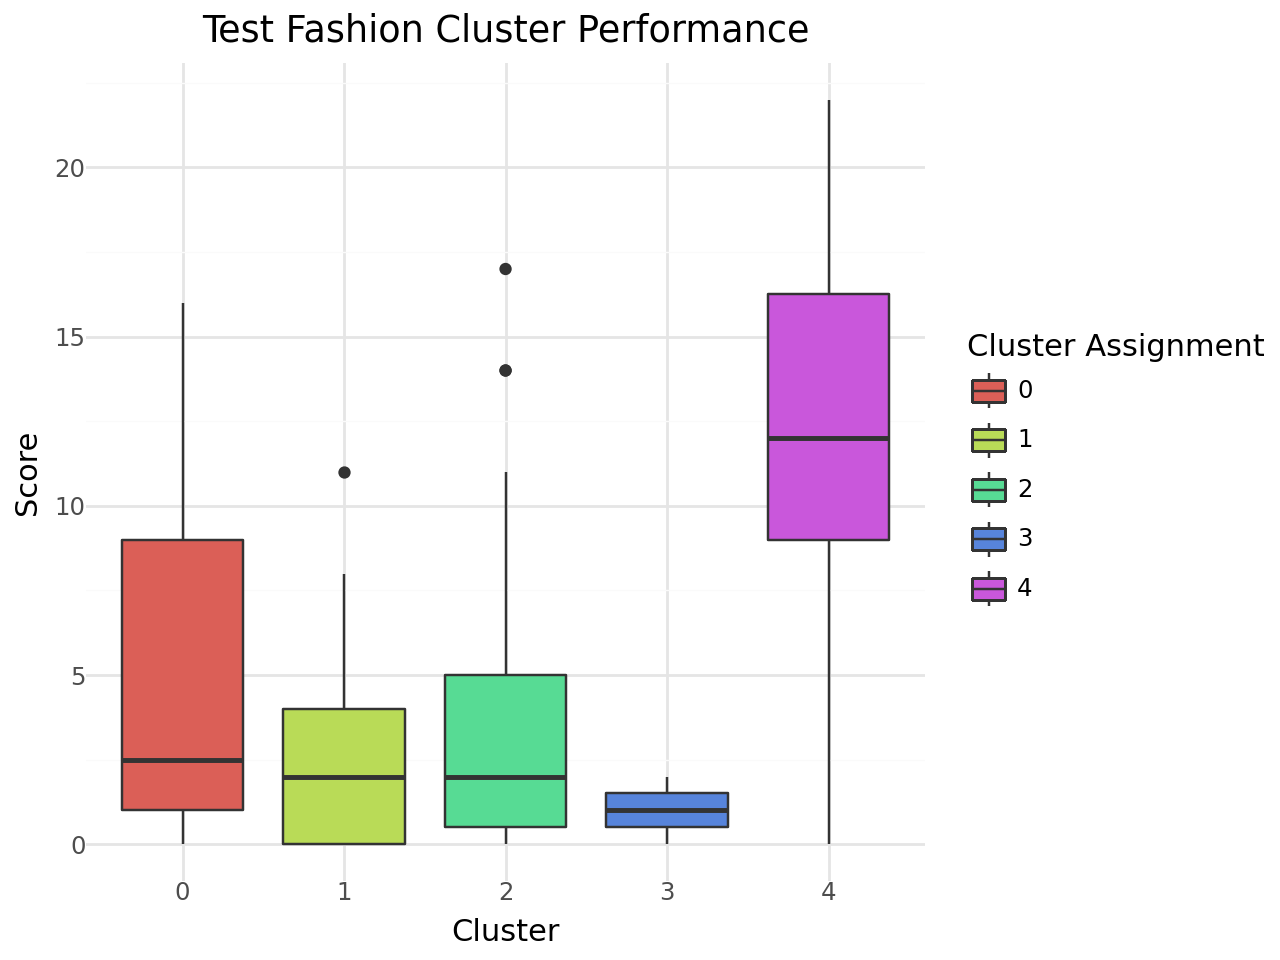

In [ ]:
gg_list[2]

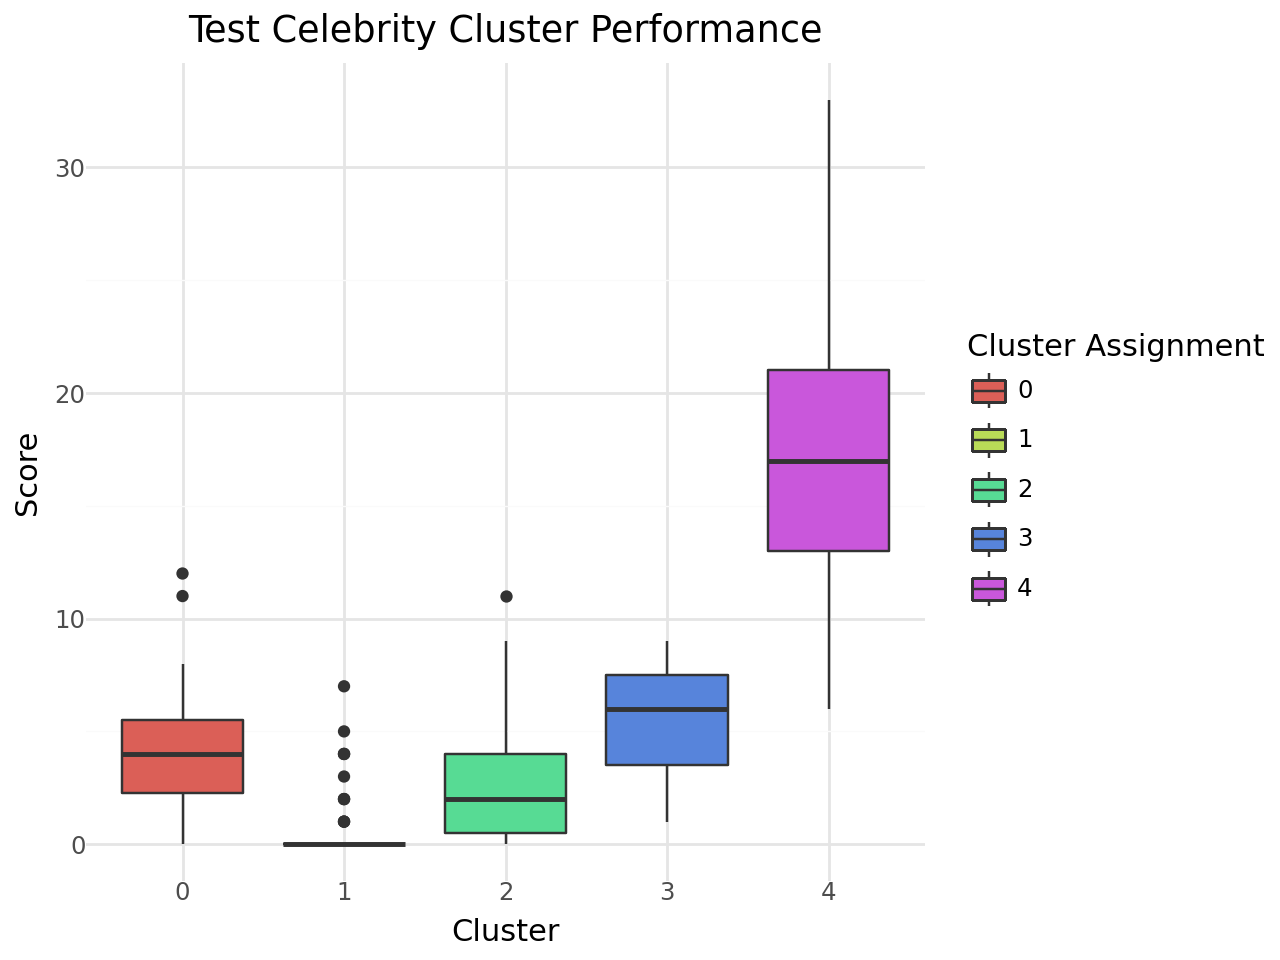

In [ ]:
gg_list[3]

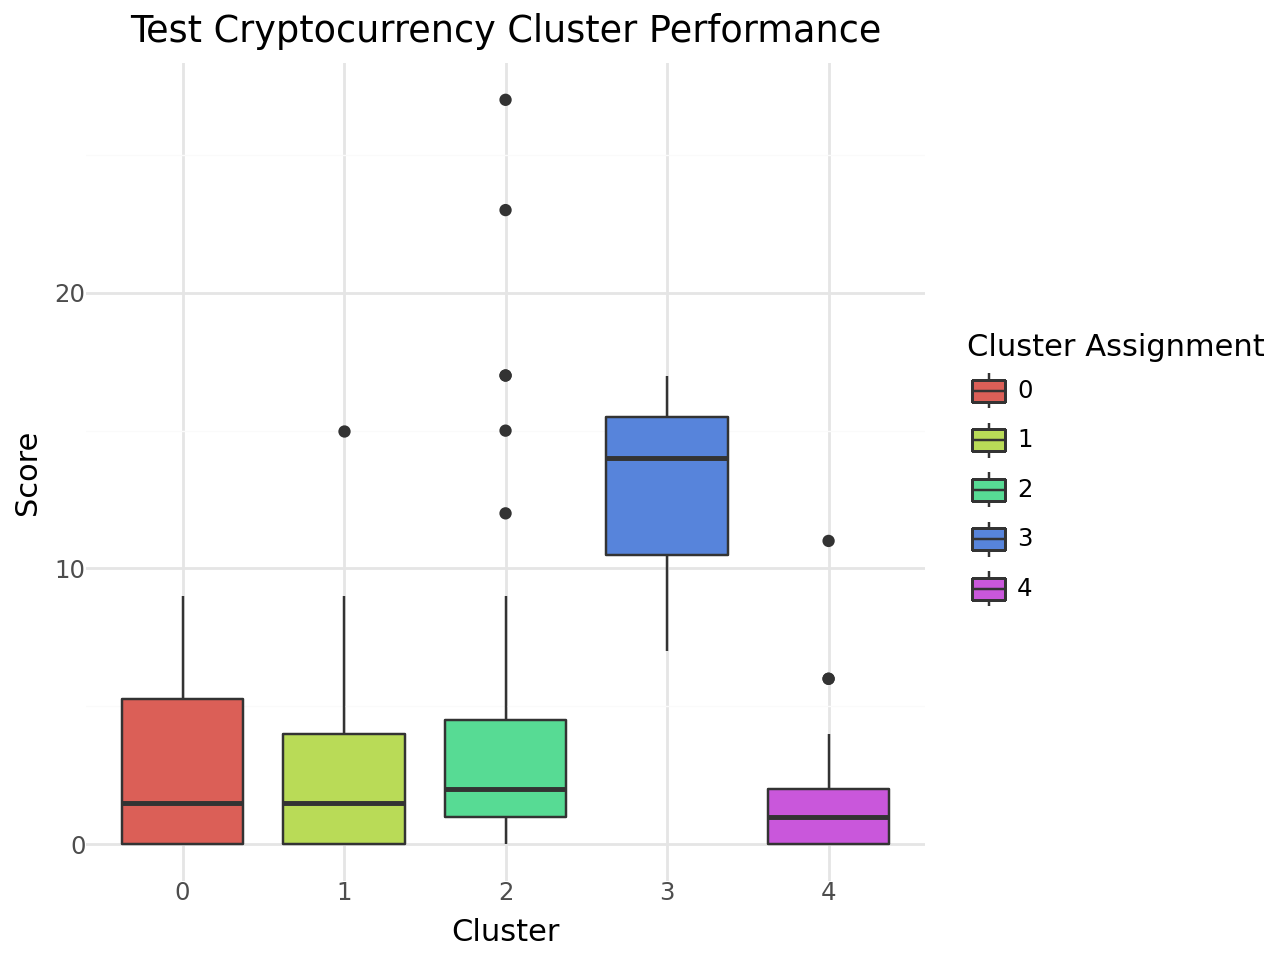

In [ ]:
gg_list[4]

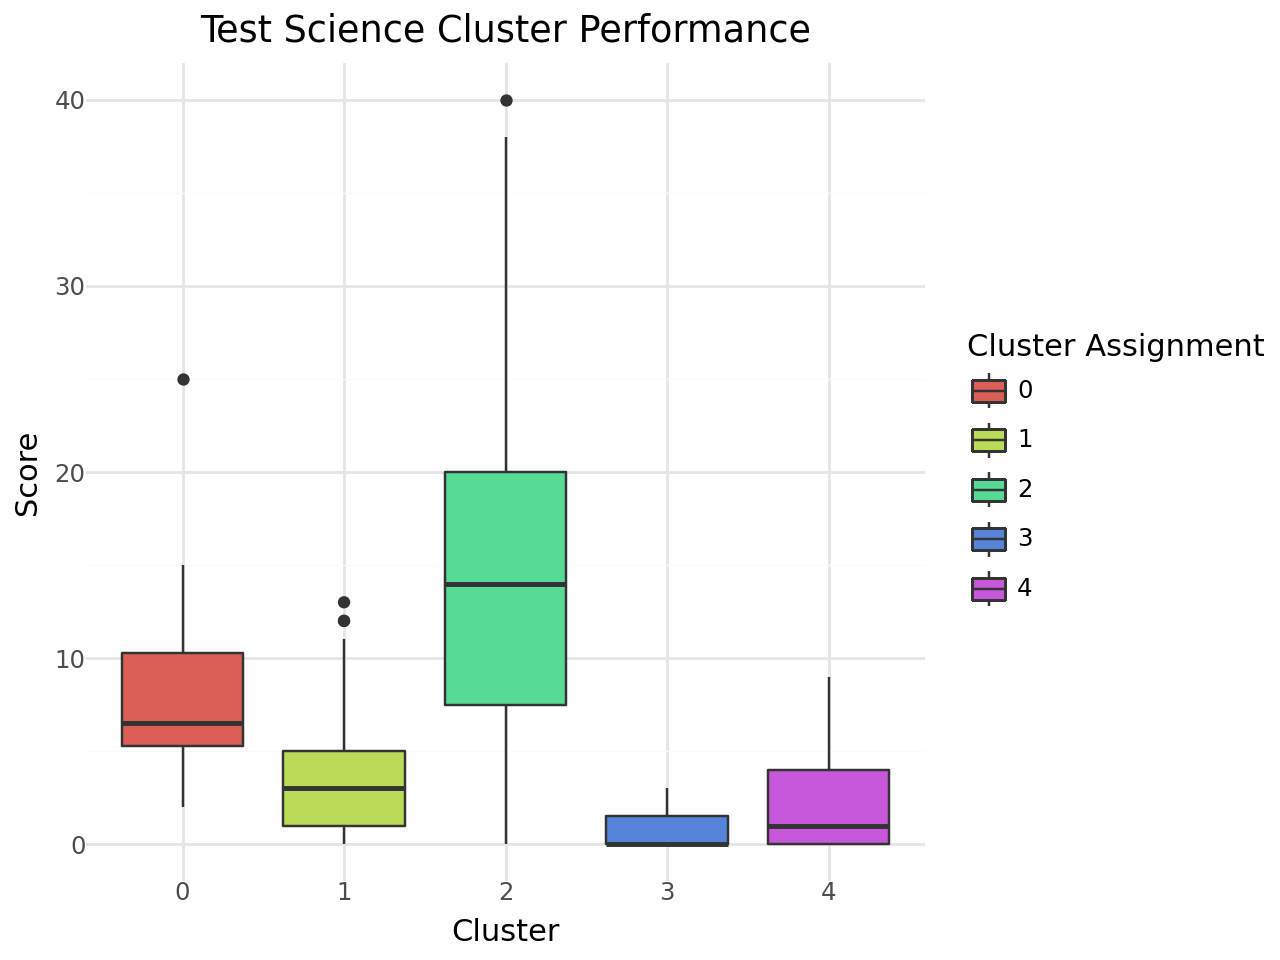

In [ ]:
gg_list[5]

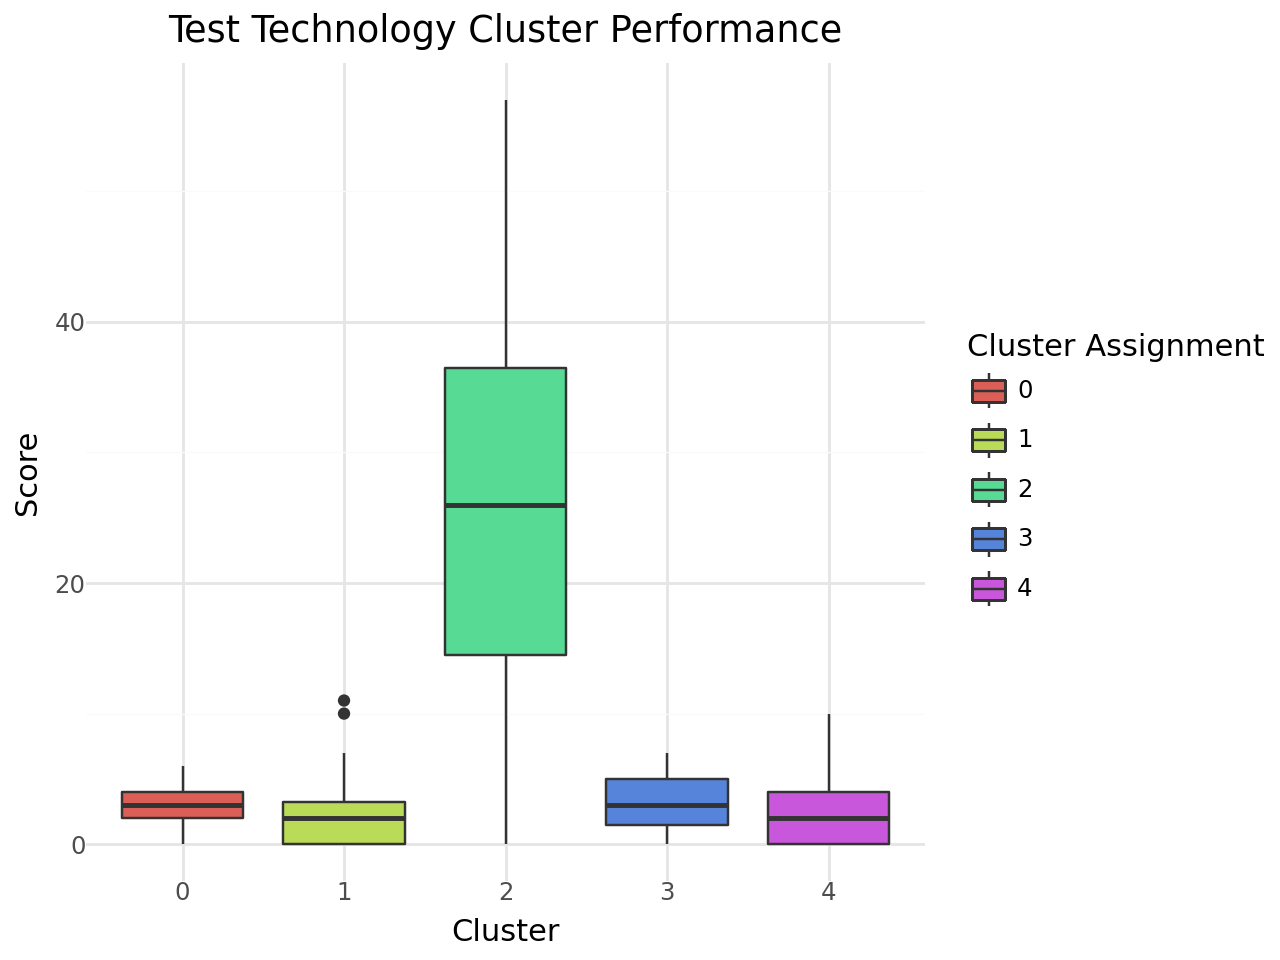

In [ ]:
gg_list[6]

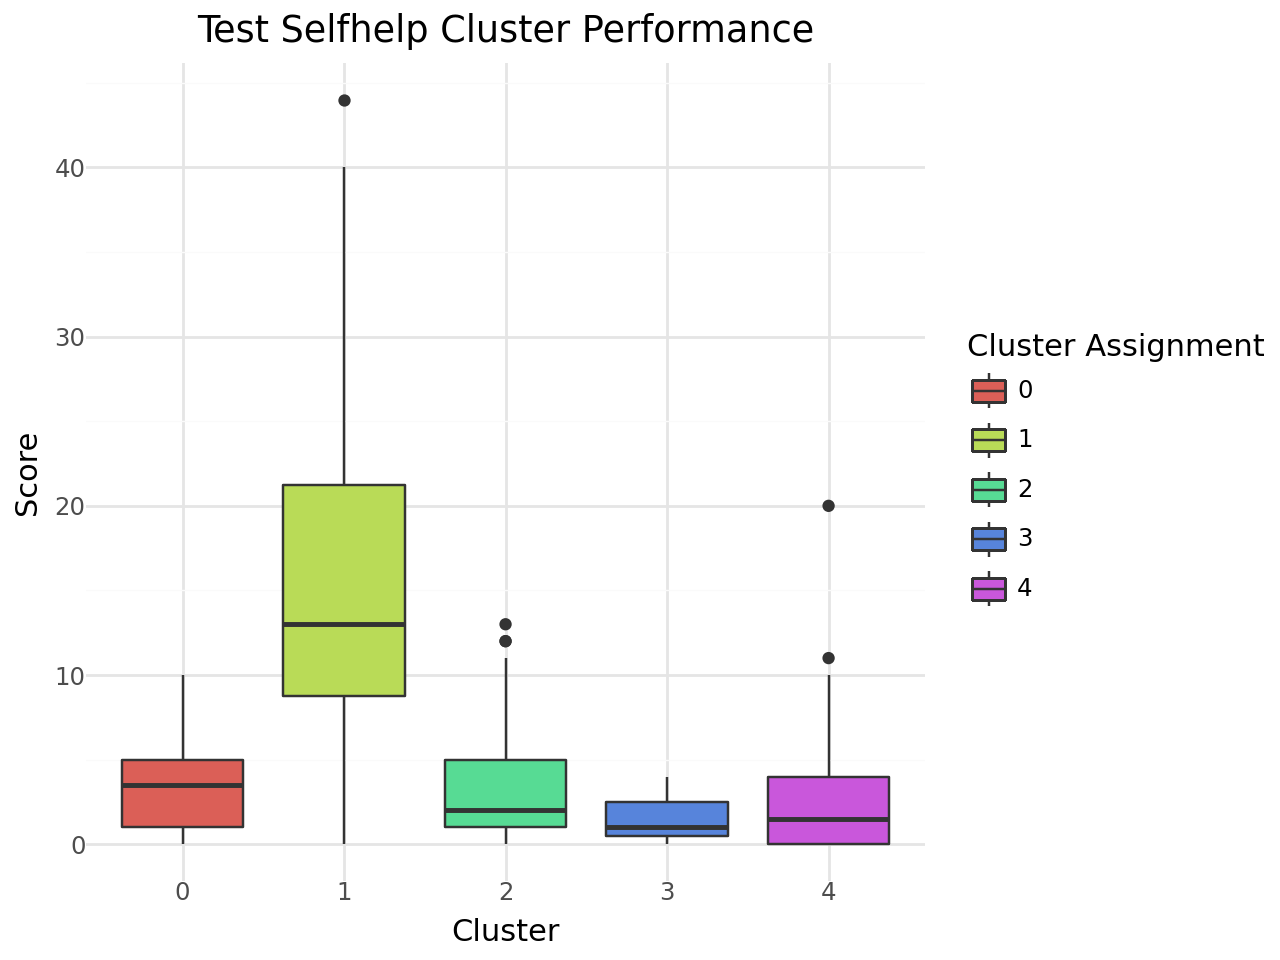

In [ ]:
gg_list[7]

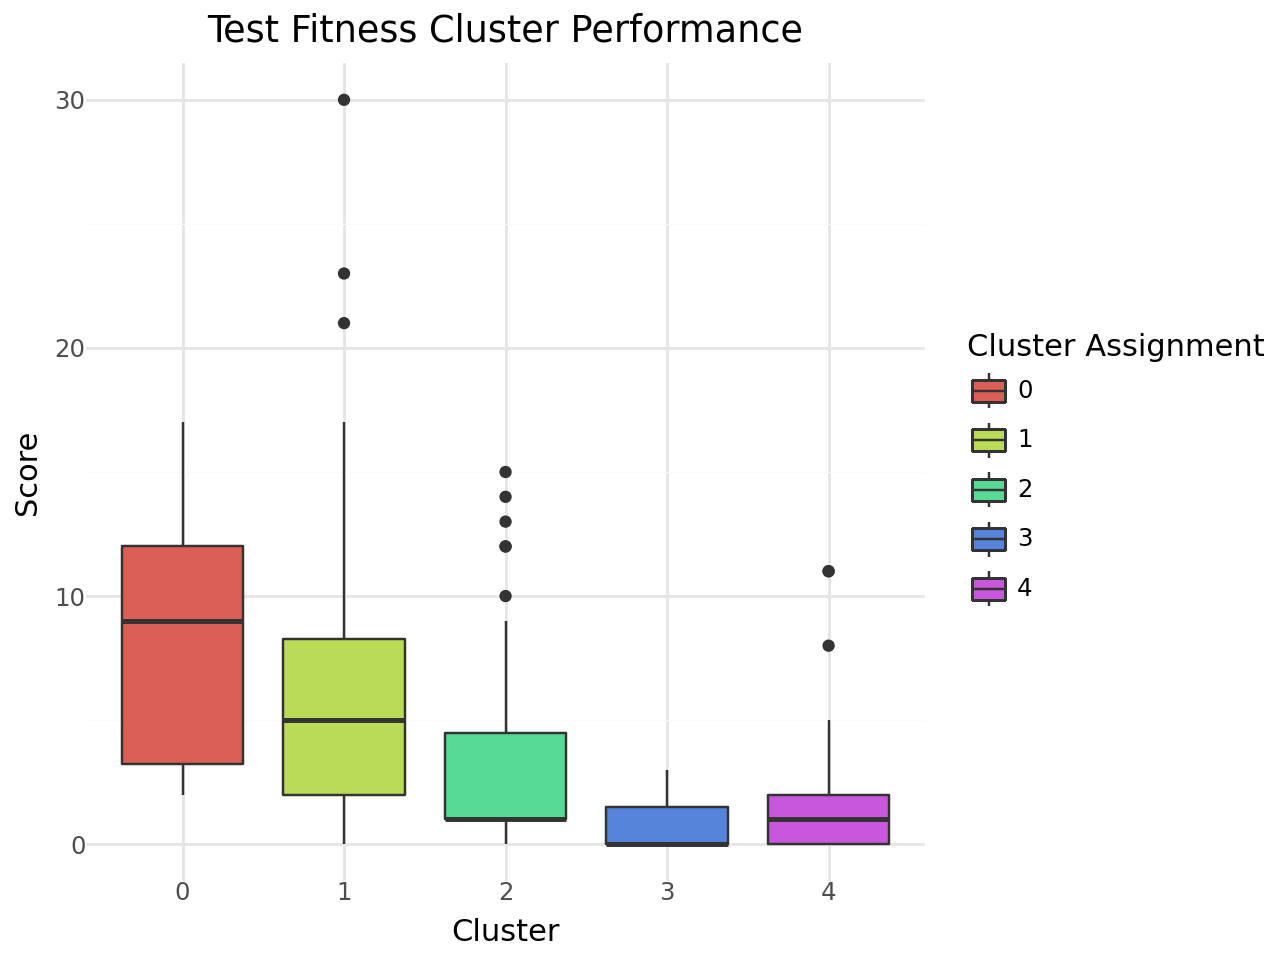

In [ ]:
gg_list[8]

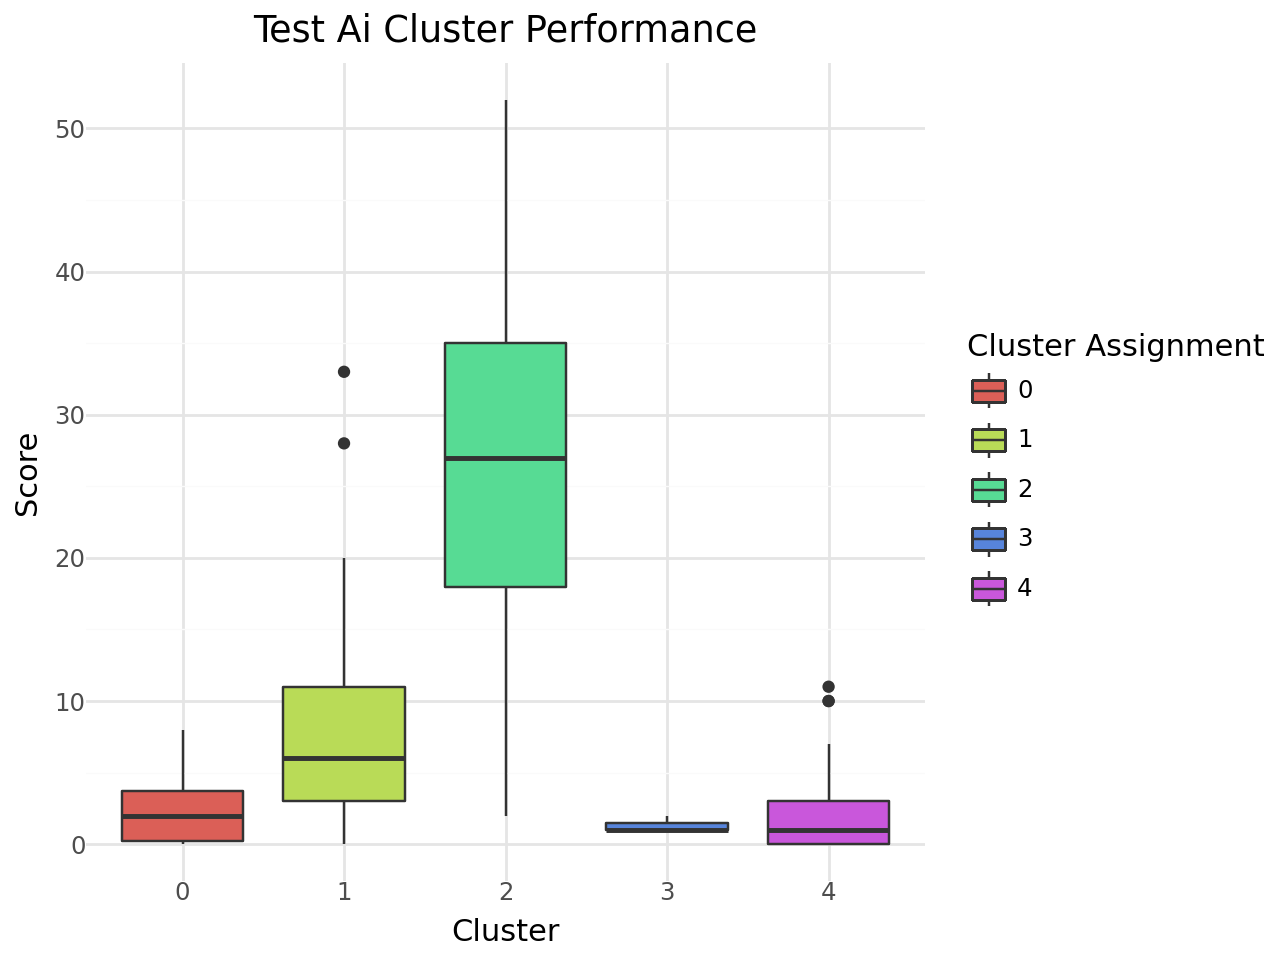

In [ ]:
gg_list[9]

In [ ]:
# other summary (got help from ChatGPT)
clusters = hac.fit_predict(article.drop(columns=['id']))

article['cluster'] = clusters

summary_table = article.groupby('cluster').mean().reset_index()
print(summary_table)


   cluster    Stocks  Productivity    Fashion  Celebrity  Cryptocurrency  \
0        0  2.000000      2.642857   5.214286   4.571429        2.714286   
1        1  9.544118     11.191176   2.308824   0.529412        2.500000   
2        2  3.508475      3.779661   3.220339   2.745763        4.033898   
3        3  5.000000      5.000000   1.000000   5.333333       12.666667   
4        4  1.910714      2.767857  12.607143  17.250000        1.517857   

     Science  Technology   SelfHelp   Fitness         AI          id  \
0   8.142857    2.857143   3.642857  8.142857   2.642857  106.285714   
1   3.867647    2.279412  15.044118  6.426471   7.794118   95.323529   
2  14.271186   26.169492   3.355932  3.355932  26.101695  100.983051   
3   1.000000    3.333333   1.666667  1.000000   1.333333   73.666667   
4   2.000000    2.517857   2.892857  1.607143   1.928571  106.267857   

   cluster_5  
0        0.0  
1        1.0  
2        2.0  
3        3.0  
4        4.0  
